# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics            import confusion_matrix
from sklearn.metrics            import ConfusionMatrixDisplay

In [41]:
X_ = pd.read_csv('input/X_train.csv')
X_test = pd.read_csv('input/X_test.csv')

y_ = pd.read_csv('input/y_train.csv').drop(columns=['Unnamed: 0'])
y_test = pd.read_csv('input/y_test.csv').drop(columns=['Unnamed: 0'])

In [42]:
X_['Index'] = X_.index 
X_.set_index(['Index', 'Subject_train'], inplace=True)
X_test['Index'] = X_test.index 
X_test.set_index(['Index', 'Subject_test'], inplace=True)

### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=.25, random_state=42)
X_.shape,X_train.shape,X_valid.shape


((7352, 561), (5514, 561), (1838, 561))

### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

In [44]:
arvore = DecisionTreeClassifier(max_depth=4,random_state=42).fit(X_train,y_train)
arvore

DecisionTreeClassifier(max_depth=4, random_state=42)

In [45]:
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': arvore.feature_importances_})
importance_df.set_index('Feature', inplace=True)

importance = importance_df.nlargest(3, 'Importance')
print(importance)

importance_list = importance.index
importance_list





                                 Importance
Feature                                    
tGravityAcc-min()-X                0.285303
fBodyAccJerk-bandsEnergy()-1,16    0.254091
tGravityAcc-mean()-Y               0.164608


Index(['tGravityAcc-min()-X', 'fBodyAccJerk-bandsEnergy()-1,16',
       'tGravityAcc-mean()-Y'],
      dtype='object', name='Feature')

### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

In [46]:
X_train = X_train[importance_list]
X_test = X_test[importance_list]
X_valid = X_valid[importance_list]
X_train.head(2)


,,tGravityAcc-min()-X,"fBodyAccJerk-bandsEnergy()-1,16",tGravityAcc-mean()-Y
Index,Subject_train,,,
6593,28,0.909123,-0.518129,-0.250282
3519,17,-0.168695,-0.999992,0.780347


In [47]:
arvore02 = DecisionTreeClassifier(random_state=42)
path = arvore02.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = path.ccp_alphas,path.impurities
print(ccp_alphas.shape)

(276,)


In [48]:
print(f"existem apenas valores positivos em ccp_alphas: {(ccp_alphas > 0).any()}\n")
ccp_alphas = np.unique(ccp_alphas[ccp_alphas > 0])
print(f"existem apenas valores únicos em ccp_alphas: {len(ccp_alphas) == len(set(ccp_alphas))}")
ccp_alphas.shape

existem apenas valores positivos em ccp_alphas: True

existem apenas valores únicos em ccp_alphas: True


(214,)

In [49]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    clfs.append(clf)

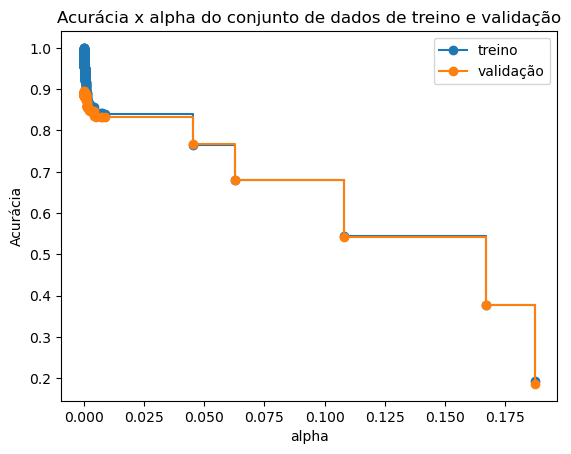

In [50]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
valid_scores = [clf.score(X_valid, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e validação")
ax.plot(ccp_alphas, train_scores, marker='o', label="treino",
        drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="validação",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [51]:
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.2f}')

melhor_arvore

Acurácia da melhor árvore na base de validação: 89.45


DecisionTreeClassifier(ccp_alpha=0.0002845570582240876, random_state=42)

### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

Acurácia: 68.51


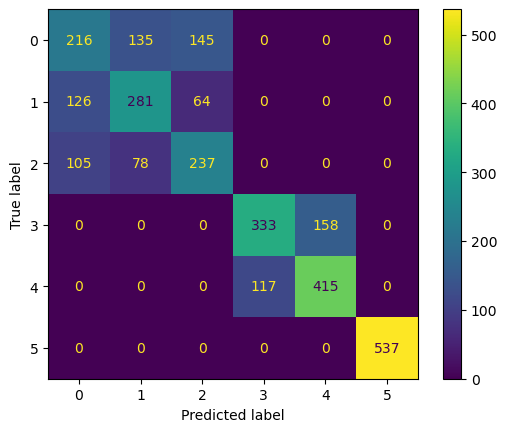

In [52]:
acuracia_teste = melhor_arvore.score(X_test, y_test)

print(f'Acurácia: {acuracia_teste*100:.2f}')

cm = confusion_matrix(y_test, melhor_arvore.predict(X_test));
MatrizDeConfusao = ConfusionMatrixDisplay(confusion_matrix=cm);

MatrizDeConfusao.plot();